# Intro

In [1]:
'''
# Esempio: aprire e visualizzare un file FITS
# Inserisci il percorso del file FITS quando richiesto, es: ./my_image.fits
filename = input("Percorso file FITS (es. ./image.fits): ").strip()
if not filename:
    print("Nessun file specificato. Inserisci il percorso del file .fits e riesegui la cella.")
else:
    try:
        from astropy.io import fits
        from astropy.table import Table
        import numpy as np
        import matplotlib.pyplot as plt
        from astropy.visualization import simple_norm
        from IPython.display import display
    except ImportError as e:
        print("Manca astropy o altri pacchetti richiesti.")
        print("Installa con: pip install astropy matplotlib")
        raise

    try:
        hdul = fits.open(filename)
    except Exception as e:
        print("Errore aprendo il file:", e)
    else:
        print("HDUs nel file:")
        image_hdu = None
        table_hdu = None
        image_idx = None
        for i, h in enumerate(hdul):
            # mostro nome e dimensione se disponibile
            naxis = h.header.get('NAXIS')
            print(i, h.__class__.__name__, 'NAME=', h.name, 'NAXIS=', naxis)
            if image_hdu is None and hasattr(h, 'data') and h.data is not None:
                # consideriamo dati immagine se hanno almeno 2 dim
                if getattr(h.data, 'ndim', 0) >= 2:
                    image_hdu = h
                    image_idx = i
            # table HDU check
            try:
                from astropy.io.fits.hdu.table import _TableBaseHDU
                if isinstance(h, _TableBaseHDU) and table_hdu is None:
                    table_hdu = h
            except Exception:
                pass

        if image_hdu is not None:
            data = image_hdu.data
            # se hanno più di 2 dimensioni, riduco prendendo la media lungo la prima asse
            if data.ndim > 2:
                data = np.mean(data, axis=0)
            norm = simple_norm(data, 'sqrt', percent=99.)
            plt.figure(figsize=(8,6))
            plt.imshow(data, origin='lower', cmap='gray', norm=norm)
            plt.colorbar(label='counts')
            plt.title(f"Immagine: HDU {image_idx} - {image_hdu.name}")
            plt.show()
        else:
            print("Nessuna HDU immagine trovata nel file.")

        if table_hdu is not None:
            print("\nLettura della prima tabella HDU trovata:")
            t = Table.read(table_hdu)
            display(t[:10])
        else:
            print("Nessuna tabella trovata nel file.")

        hdul.close()
'''

'\n# Esempio: aprire e visualizzare un file FITS\n# Inserisci il percorso del file FITS quando richiesto, es: ./my_image.fits\nfilename = input("Percorso file FITS (es. ./image.fits): ").strip()\nif not filename:\n    print("Nessun file specificato. Inserisci il percorso del file .fits e riesegui la cella.")\nelse:\n    try:\n        from astropy.io import fits\n        from astropy.table import Table\n        import numpy as np\n        import matplotlib.pyplot as plt\n        from astropy.visualization import simple_norm\n        from IPython.display import display\n    except ImportError as e:\n        print("Manca astropy o altri pacchetti richiesti.")\n        print("Installa con: pip install astropy matplotlib")\n        raise\n\n    try:\n        hdul = fits.open(filename)\n    except Exception as e:\n        print("Errore aprendo il file:", e)\n    else:\n        print("HDUs nel file:")\n        image_hdu = None\n        table_hdu = None\n        image_idx = None\n        for i

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from scipy.optimize import curve_fit
from functools import reduce
import pandas as pd

In [3]:
tab = Table.read ('3DHST_Allfields.fits')
print (tab.colnames)

['id', 'fieldnr', 'field', 'ra', 'dec', 'm_F140W', 'z_best', 'z_best_l68', 'z_best_u68', 'ltau', 'lage', 'Av', 'lmass', 'lsfr', 'UmV', 'VmJ']


# 1 - Preliminar plot

In [4]:
z = tab['z_best']
zbin = np.percentile (z, [0, 25, 50, 75, 100])
print (zbin)

       z_best      
-------------------
0.22689999639987946
 0.8294199705123901
  1.164199948310852
 1.6591299772262573
 2.9928300380706787


In [5]:
z1 = np.where ((z >= zbin[0]) & (z < zbin[1]))
z2 = np.where ((z >= zbin[1]) & (z < zbin[2]))
z3 = np.where ((z >= zbin[2]) & (z < zbin[3]))
z4 = np.where ((z >= zbin[3]) & (z <= zbin[4]))

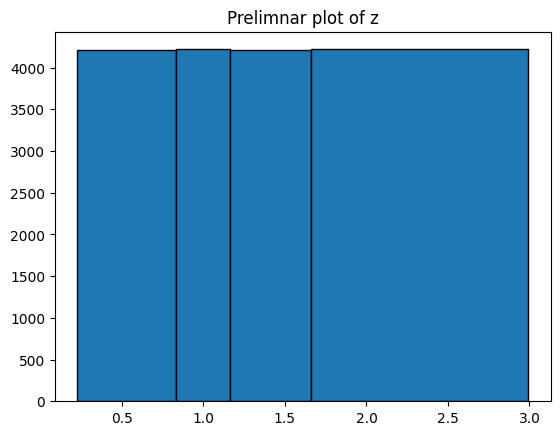

In [6]:
plt.hist (z, bins=zbin, edgecolor='black')
plt.title ('Prelimnar plot of z')
plt.show()

# 2 - UV vs VJ

In [7]:
UV = tab['UmV']
VJ = tab['VmJ']
Av = tab['Av']
sSFR = tab['lsfr'] - tab['lmass']

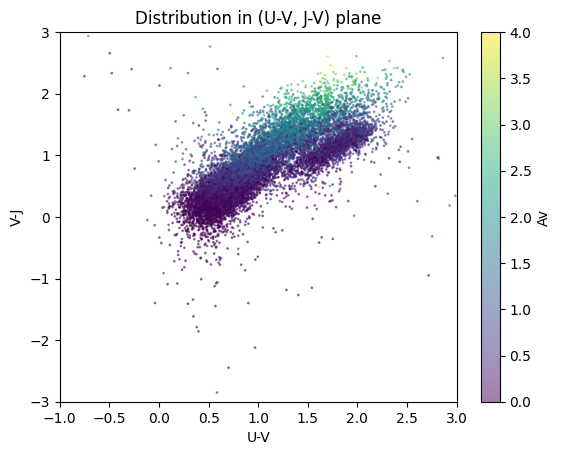

In [ ]:
plt.scatter (UV, VJ, s=1, c=Av, alpha = 0.5)
plt.xlabel ('U-V')
plt.ylabel ('V-J')
plt.ylim (-3, 3)
plt.xlim (-1,3)
plt.title ('Distribution in (U-V, J-V) plane')
plt.colorbar().set_label ('Av')
plt.show()

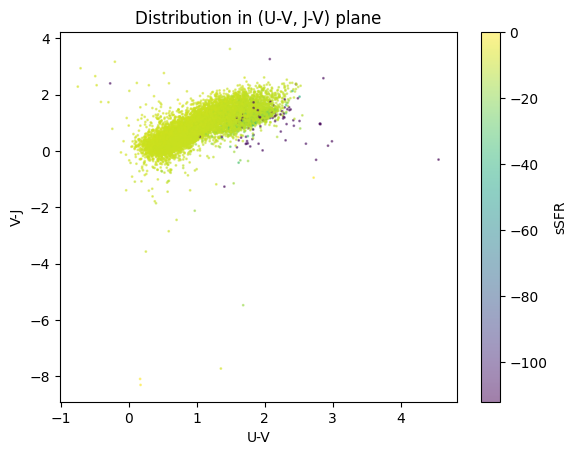

In [9]:
plt.scatter (UV, VJ, s=1, c=sSFR, alpha=0.5)
plt.xlabel ('U-V')
plt.ylabel ('V-J')
plt.title ('Distribution in (U-V, J-V) plane')
plt.colorbar().set_label ('sSFR')
plt.show()

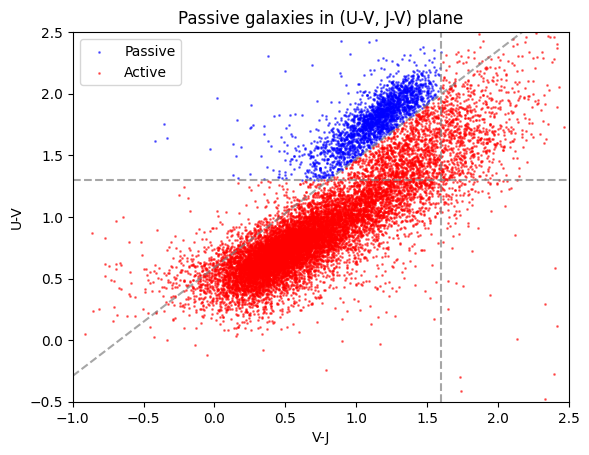

In [43]:
x=np.linspace (-1, 3, 100)

def line (x, a, b):
    return a*x + b

UVJpassive = np.where ((UV > 0.88*VJ+0.59) & (UV > 1.3) & (VJ < 1.6))
UVJactive = np.where ((UV <= 0.88*VJ+0.59) | (UV <= 1.3) | (VJ >= 1.6))
plt.scatter (VJ[UVJpassive], UV[UVJpassive], s=1, c='blue', alpha=0.5, label='Passive')
plt.scatter (VJ[UVJactive], UV[UVJactive], s=1, c='red', alpha=0.5, label='Active')
plt.plot (x, line (x, 0.88, 0.59), c='grey', ls='--', alpha =0.7)
plt.plot (x, line (x, 0, 1.3), c='grey', ls='--', alpha =0.7)
plt.axvline(x=1.6, c='grey', ls='--', alpha =0.7)
plt.ylabel ('U-V')
plt.xlabel ('V-J')
plt.ylim (-0.5, 2.5)
plt.xlim (-1,2.5)
plt.title ('Passive galaxies in (U-V, J-V) plane')
plt.legend()
plt.show()

# 3 - Stellar Mass vs SFR

In [11]:
lmass = tab['lmass']

In [12]:
bin1 = np.where ((z[UVJactive] >= zbin[0]) & (z[UVJactive] < zbin[1]))
bin2 = np.where ((z[UVJactive] >= zbin[1]) & (z[UVJactive] < zbin[2]))
bin3 = np.where ((z[UVJactive] >= zbin[2]) & (z[UVJactive] < zbin[3]))
bin4 = np.where ((z[UVJactive] >= zbin[3]) & (z[UVJactive] <= zbin[4]))

In [13]:
def func (x, m, q): return m*x + q

[-0.32116331 -7.30397831]


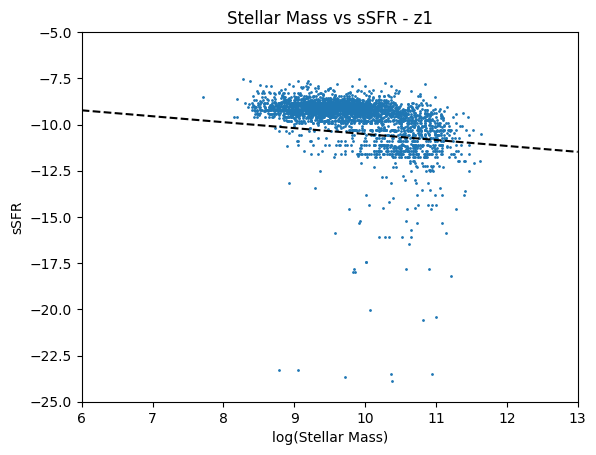

In [14]:
x = np.linspace (6, 13, 100)

popt1, pcov1 = curve_fit(f=func, xdata=lmass[bin1],  ydata=sSFR[bin1], p0=[1,1])
print (popt1)

plt.scatter (lmass[bin1], sSFR[bin1], s=1)
plt.plot (x, func(x, *popt1), color='black', linestyle='dashed')
plt.xlim (6, 13)
plt.ylim (-25,-5)
plt.xlabel ('log(Stellar Mass)')
plt.ylabel ('sSFR')
plt.title ('Stellar Mass vs sSFR - z1')
plt.show()

[-0.34563175 -7.28731526]


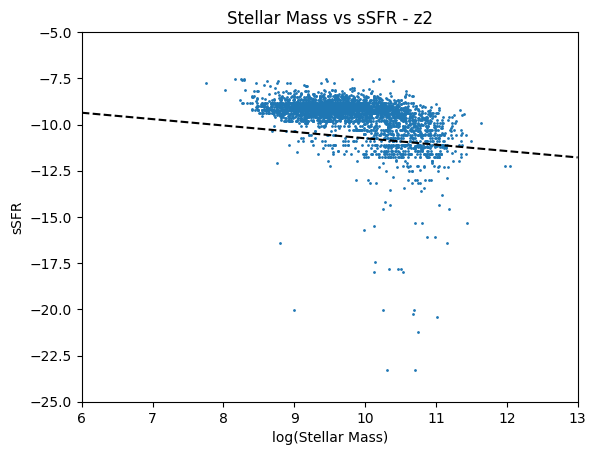

In [15]:
x = np.linspace (6, 13, 100)

popt2, pcov2 = curve_fit(f=func, xdata=lmass[bin2],  ydata=sSFR[bin2], p0=[1,1])
print (popt2)

plt.scatter (lmass[bin2], sSFR[bin2], s=1)
plt.plot (x, func(x, *popt2), color='black', linestyle='dashed')
plt.xlim (6, 13)
plt.ylim (-25,-5)
plt.xlabel ('log(Stellar Mass)')
plt.ylabel ('sSFR')
plt.title ('Stellar Mass vs sSFR - z2')
plt.show()

[-0.14627135 -8.8513948 ]


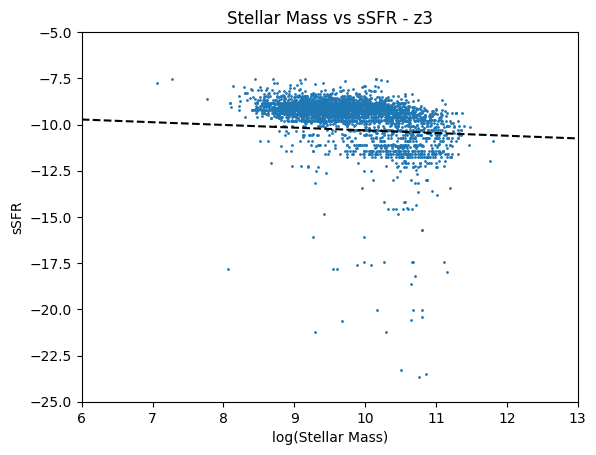

In [16]:
x = np.linspace (6, 13, 100)

popt3, pcov3 = curve_fit(f=func, xdata=lmass[bin3],  ydata=sSFR[bin3], p0=[1,1])
print (popt3)

plt.scatter (lmass[bin3], sSFR[bin3], s=1)
plt.plot (x, func(x, *popt3), color='black', linestyle='dashed')
plt.xlim (6, 13)
plt.ylim (-25,-5)
plt.xlabel ('log(Stellar Mass)')
plt.ylabel ('sSFR')
plt.title ('Stellar Mass vs sSFR - z3')
plt.show()

[-1.44310942  3.3677109 ]


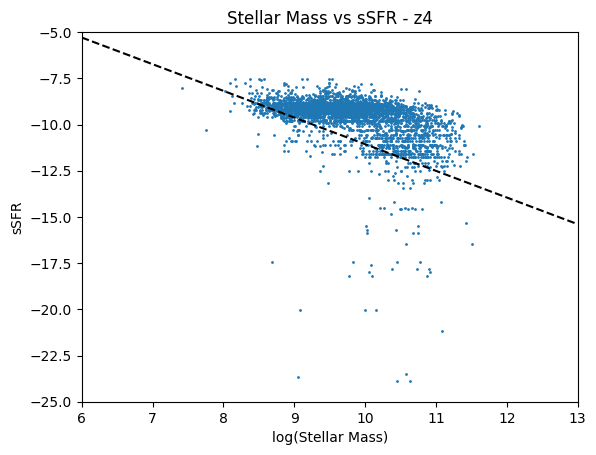

In [17]:
x = np.linspace (6, 13, 100)

popt4, pcov4 = curve_fit(f=func, xdata=lmass[bin4],  ydata=sSFR[bin4], p0=[1,1])
print (popt4)

plt.scatter (lmass[bin4], sSFR[bin4], s=1)
plt.plot (x, func(x, *popt4), color='black', linestyle='dashed')
plt.xlim (6, 13)
plt.ylim (-25,-5)
plt.xlabel ('log(Stellar Mass)')
plt.ylabel ('sSFR')
plt.title ('Stellar Mass vs sSFR - z4')
plt.show()

# 4 - Passive galaxies fraction vs Stellar Mass

In [18]:
az1 = reduce (np.intersect1d, [UVJactive, z1])
pz1 = reduce (np.intersect1d, [UVJpassive, z1])
az2 = reduce (np.intersect1d, [UVJactive, z2])
pz2 = reduce (np.intersect1d, [UVJpassive, z2])
az3 = reduce (np.intersect1d, [UVJactive, z3])
pz3 = reduce (np.intersect1d, [UVJpassive, z3])
az4 = reduce (np.intersect1d, [UVJactive, z4])
pz4 = reduce (np.intersect1d, [UVJpassive, z4])

In [19]:
m_az1 = lmass[az1]
m_pz1 = lmass[pz1]
m_az2 = lmass[az2]
m_pz2 = lmass[pz2]
m_az3 = lmass[az3]
m_pz3 = lmass[pz3]
m_az4 = lmass[az4]
m_pz4 = lmass[pz4]

In [20]:
hist_mpz1, bins_mpz1 = np.histogram(m_pz1, bins = 8)
hist_maz1, bins_maz1 = np.histogram(m_az1, bins = bins_mpz1)
frac_mpz1 = hist_mpz1 / (hist_mpz1 + hist_maz1)

hist_mpz2, bins_mpz2 = np.histogram(m_pz2, bins = bins_mpz1)
hist_maz2, bins_maz2 = np.histogram(m_az2, bins = bins_mpz1)
frac_mpz2 = hist_mpz2 / (hist_mpz2 + hist_maz2)

hist_mpz3, bins_mpz3 = np.histogram(m_pz3, bins = bins_mpz1)
hist_maz3, bins_maz3 = np.histogram(m_az3, bins = bins_mpz1)
frac_mpz3 = hist_mpz3 / (hist_mpz3 + hist_maz3)

hist_mpz4, bins_mpz4 = np.histogram(m_pz4, bins = bins_mpz1)
hist_maz4, bins_maz4 = np.histogram(m_az4, bins = bins_mpz1)
frac_mpz4 = hist_mpz4 / (hist_mpz4 + hist_maz4)
frac_mpz4 = np.nan_to_num(frac_mpz4, nan=0.0)

bins_centers = (bins_mpz1[1:] + bins_mpz1[:-1])/2

/var/folders/qk/_k66m61n20l_yhkclqkkp8780000gn/T/ipykernel_6226/1935064717.py:15: RuntimeWarning: invalid value encountered in divide
  frac_mpz4 = hist_mpz4 / (hist_mpz4 + hist_maz4)


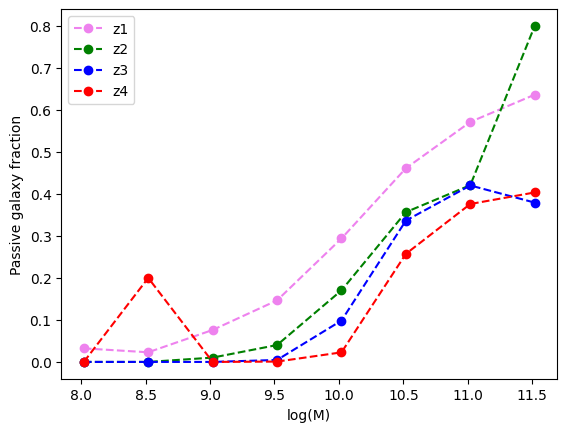

In [21]:
plt.plot (bins_centers, frac_mpz1, color = 'violet', linestyle='dashed', marker='o', label='z1')
plt.plot (bins_centers, frac_mpz2, color = 'green', linestyle='dashed', marker='o', label='z2')
plt.plot (bins_centers, frac_mpz3, color = 'blue', linestyle='dashed', marker='o', label='z3')
plt.plot (bins_centers, frac_mpz4, color = 'red', linestyle='dashed', marker='o', label='z4')
plt.xlabel ('log(M)')
plt.ylabel ('Passive galaxy fraction')
plt.legend()
plt.show()